In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba import Mamba, MambaConfig
import argparse
from datetime import datetime
from sklearn.decomposition import PCA

/home/luchinwei/anaconda3/envs/mambastock/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_dir = '0728_2330_value_pca_7/'
use_cuda = True
seed_num = 100
epochs = 1000
loss_fnc = F.smooth_l1_loss
lr = 0.001
wd = 1e-5
hidden = 16
layer = 3
n_test = 350
ts_code = 2330
risk_free = 0.017


In [3]:
def evaluation_metric(y_test,y_hat):
    MSE = mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = mean_absolute_error(y_test,y_hat)
    R2 = r2_score(y_test,y_hat)
    print('%.4f %.4f %.4f %.4f' % (MSE,RMSE,MAE,R2))

def set_seed(seed,cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

def dateinf(series, n_test):
    lt = len(series)
    print('Training start',series[0])
    print('Training end',series[lt-n_test-1])
    print('Testing start',series[lt-n_test])
    print('Testing end',series[lt-1])

set_seed(seed_num,use_cuda)

class Net(nn.Module):
    def __init__(self, in_dim, out_dim, use_pca=False, pca_dim=None, pca_components=None):
        super().__init__()
        self.use_pca = use_pca

        if self.use_pca:
            assert pca_dim is not None and pca_components is not None, "需提供 pca_dim 和 pca_components"
            self.pca_layer = nn.Linear(in_dim, pca_dim, bias=False)
            self.pca_layer.weight.data = torch.tensor(pca_components, dtype=torch.float32)
            self.pca_layer.weight.requires_grad = False  # 若不希望訓練 PCA 權重
            in_dim = pca_dim  # 更新模型輸入維度

        self.config = MambaConfig(d_model=hidden, n_layers=layer)
        self.mamba = nn.Sequential(
            nn.Linear(in_dim, hidden),
            Mamba(self.config),
            nn.Linear(hidden, out_dim),
            # nn.Tanh()
        )

    def forward(self, x):
        if self.use_pca:
            x = self.pca_layer(x)
        x = self.mamba(x)
        return x.flatten()

def PredictWithData(trainX, trainy, testX, save_dir,use_pca=False, pca_dim=None, pca_components=None, val_ratio=0.2, patience=150, loss_fnc=None):
    clf = Net(in_dim=trainX.shape[1], out_dim=1, use_pca=use_pca, pca_dim=pca_dim, pca_components=pca_components)

    opt = torch.optim.Adam(clf.parameters(),lr=lr,weight_decay=wd)
    
    val_size = int(len(trainX) * val_ratio)
    
    X_train = trainX[:-val_size]
    y_train = trainy[:-val_size]
    X_val = trainX[-val_size:]
    y_val = trainy[-val_size:]
    
    xt = torch.from_numpy(X_train).float().unsqueeze(1)
    xv = torch.from_numpy(X_val).float().unsqueeze(1)
    x_test = torch.from_numpy(testX).float().unsqueeze(1)
    yt = torch.from_numpy(y_train).float()
    yv = torch.from_numpy(y_val).float()
    
    if loss_fnc is None:
        loss_fnc = F.mse_loss
    
    best_val_loss = np.inf
    best_epoch = 0
    best_state_dict = None
    
    if use_cuda:
        clf = clf.cuda()
        xt, xv, x_test = xt.cuda(), xv.cuda(), x_test.cuda()
        yt, yv = yt.cuda(), yv.cuda()
    
    for e in range(epochs):
        clf.train()
        pred = clf(xt)
        loss = loss_fnc(pred, yt)

        opt.zero_grad()
        loss.backward()
        opt.step()

        clf.eval()
        with torch.no_grad():
            val_pred = clf(xv)
            val_loss = loss_fnc(val_pred, yv)

        print(f'Epoch {e:03d} | Val Loss: {val_loss.item():.4f}')
        
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_epoch = e
            best_state_dict = clf.state_dict()
        elif e - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {e}")
            break
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"{save_dir}model_{timestamp}.pth"
    torch.save(best_state_dict, save_path)
    print(f"Best model saved to: {save_path}")
    
    clf.load_state_dict(best_state_dict)
    clf.eval()
    mat = clf(x_test)
    if use_cuda: mat = mat.cpu()
    yhat = mat.detach().numpy().flatten()
    return yhat

## 看一下資料

In [ ]:
data = pd.read_csv(str(ts_code)+"_value"+'.csv')
# data = pd.read_csv(str(ts_code)+'.csv')
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y/%m/%d')
close = data.pop('close_TW').values
ratechg = data['close_TW_roc'].apply(lambda x:x).values
data.drop(columns=['close_TW_roc'],inplace=True)
dat = data.iloc[:,4:]


In [ ]:
dat

In [ ]:
# data = pd.read_csv(str(ts_code)+'.csv')
data = pd.read_csv(str(ts_code)+"_value"+'.csv')
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y/%m/%d')
close = data.pop('close_TW').values
ratechg = data['close_TW_roc'].apply(lambda x:x).values
data.drop(columns=['close_TW_roc'],inplace=True)
dat = data.iloc[:,4:82].values
trainX, testX = dat[:-n_test, :], dat[-n_test:, :]
trainy = ratechg[:-n_test]

In [ ]:
len(trainX)

In [ ]:
len(testX)

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
# data = pd.read_csv(str(ts_code)+'.csv')\
data = pd.read_csv(str(ts_code)+"_value"+'.csv')
corr_matrix = data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            xticklabels=False,
            yticklabels=False)

# corr_matrix.to_csv("correlation_matrix.csv")

## 開始訓練

#### 不做 pca

In [ ]:
# data = pd.read_csv(str(ts_code)+'.csv')
data = pd.read_csv(str(ts_code)+"_value"+'.csv')
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y/%m/%d')
close = data.pop('close_TW').values
ratechg = data['close_TW_roc'].apply(lambda x:x).values
data.drop(columns=['close_TW_roc'],inplace=True)
dat = data.iloc[:,4:].values
trainX, testX = dat[:-n_test, :], dat[-n_test:, :]
trainy = ratechg[:-n_test]

#### 做 pca

In [4]:
data = pd.read_csv(str(ts_code)+"_value"+'.csv')
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y/%m/%d')

# 拆離 label 欄位
close = data.pop('close_TW').values
ratechg = data['close_TW_roc'].values
data.drop(columns=['close_TW_roc'], inplace=True)

# 擷取有效特徵欄位區段
dat = data.iloc[:, 4:].values

In [5]:
use_pca = True
pca_dim = 5

if use_pca:
    # 建立 PCA 模型並訓練
    pca = PCA(n_components=pca_dim)
    pca.fit(dat)

    # 抽出主成分向量（前 pca_dim 個）
    pca_components = pca.components_[:pca_dim]  # shape: [5, 原始維度]

    # 投影資料到 PCA 空間
    dat = dat @ pca_components.T
    
trainX, testX = dat[:-n_test], dat[-n_test:]
trainy = ratechg[:-n_test]

#### 做與不做 pca 的後續

In [6]:
predictions = PredictWithData(trainX, trainy, testX, save_dir, loss_fnc=loss_fnc)
time = data['trade_date'][-n_test:]
data1 = close[-n_test:]
finalpredicted_stock_price = []
pred = close[-n_test-1]
for i in range(n_test):
    pred = close[-n_test-1+i]*(1+predictions[i])
    finalpredicted_stock_price.append(pred)

Epoch 000 | Val Loss: 0.0092
Epoch 001 | Val Loss: 0.0065
Epoch 002 | Val Loss: 0.0042
Epoch 003 | Val Loss: 0.0025
Epoch 004 | Val Loss: 0.0013
Epoch 005 | Val Loss: 0.0006
Epoch 006 | Val Loss: 0.0002
Epoch 007 | Val Loss: 0.0002
Epoch 008 | Val Loss: 0.0004
Epoch 009 | Val Loss: 0.0007
Epoch 010 | Val Loss: 0.0010
Epoch 011 | Val Loss: 0.0014
Epoch 012 | Val Loss: 0.0016
Epoch 013 | Val Loss: 0.0017
Epoch 014 | Val Loss: 0.0017
Epoch 015 | Val Loss: 0.0015
Epoch 016 | Val Loss: 0.0013
Epoch 017 | Val Loss: 0.0011
Epoch 018 | Val Loss: 0.0008
Epoch 019 | Val Loss: 0.0006
Epoch 020 | Val Loss: 0.0004
Epoch 021 | Val Loss: 0.0003
Epoch 022 | Val Loss: 0.0002
Epoch 023 | Val Loss: 0.0002
Epoch 024 | Val Loss: 0.0002
Epoch 025 | Val Loss: 0.0002
Epoch 026 | Val Loss: 0.0003
Epoch 027 | Val Loss: 0.0003
Epoch 028 | Val Loss: 0.0004
Epoch 029 | Val Loss: 0.0004
Epoch 030 | Val Loss: 0.0004
Epoch 031 | Val Loss: 0.0004
Epoch 032 | Val Loss: 0.0004
Epoch 033 | Val Loss: 0.0003
Epoch 034 | Va

Training start 2014-09-26 00:00:00
Training end 2023-12-26 00:00:00
Testing start 2023-12-27 00:00:00
Testing end 2025-07-08 00:00:00
MSE RMSE MAE R2
436.8034 20.8998 15.0520 0.9784


/home/luchinwei/anaconda3/envs/mambastock/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


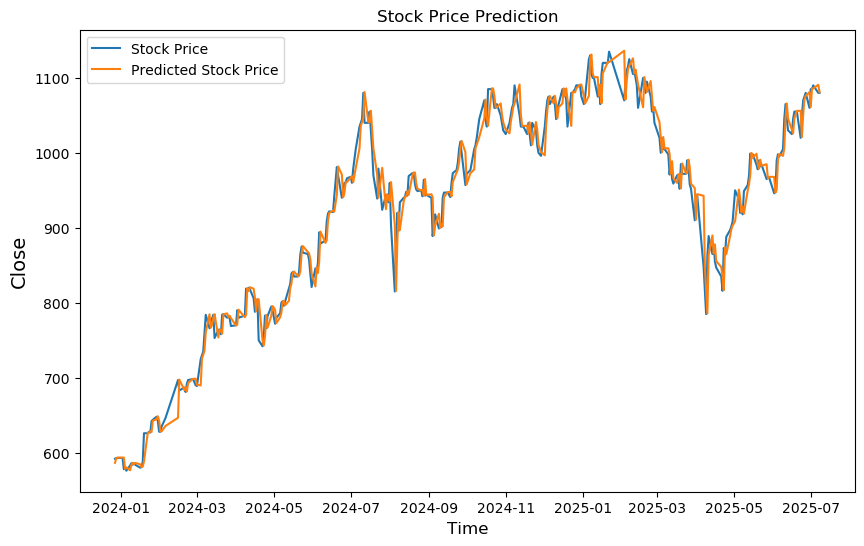

In [7]:
dateinf(data['trade_date'],n_test)
print('MSE RMSE MAE R2')
evaluation_metric(data1, finalpredicted_stock_price)
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

## Test


#### 開啟訓練檔案

In [ ]:
import os

In [ ]:
for f in os.listdir(save_dir):
    print(f)

In [ ]:
file = "model_20250728_193133.pth"

In [ ]:
timestamp = file.split("_")[1] + "_" + file.split("_")[2].split(".")[0]

In [ ]:
clf = Net(len(trainX[0]),1)
clf.load_state_dict(torch.load(save_dir+file))
clf.eval()

In [ ]:
input_tensor = torch.tensor(testX, dtype=torch.float32)
input_tensor = input_tensor.unsqueeze(0)

In [ ]:
with torch.no_grad():
    predictions = clf(input_tensor)

In [ ]:
predictions

In [ ]:
len(predictions)

In [ ]:
test_return = ratechg[-n_test:]

In [ ]:
len(test_return)

#### Return Rate Distribution (Train)

In [ ]:
plt.hist(trainy, bins=50)
plt.title("2330 Return Rate Distribution (Train)")
timestamp = file.split("_")[1] + "_" + file.split("_")[2].split(".")[0]
filename = f"{ts_code}_Return_Rate_Distribution_(Train)_{timestamp}.png"
folder = '0728_2330/img'
full_path = os.path.join(folder, filename)
os.makedirs(folder, exist_ok=True)

plt.savefig(full_path, dpi=300)

plt.show()

#### Return Rate Distribution (Test)

In [ ]:
plt.hist(test_return, bins=50)
plt.title("2330 Return Rate Distribution (Test)")
timestamp = file.split("_")[1] + "_" + file.split("_")[2].split(".")[0]
filename = f"{ts_code}_Return_Rate_Distribution_(Test)_{timestamp}.png"
folder = '0728_2330/img'
full_path = os.path.join(folder, filename)
os.makedirs(folder, exist_ok=True)

plt.savefig(full_path, dpi=300)
plt.show()

#### Residual Distribution

In [ ]:
residual = predictions - test_return
plt.hist(residual.numpy(), bins=50)
plt.title("2330 Residual Distribution")
timestamp = file.split("_")[1] + "_" + file.split("_")[2].split(".")[0]
filename = f"{ts_code}_Residual_Distribution_{timestamp}.png"
folder = '0728_2330/img'
full_path = os.path.join(folder, filename)
os.makedirs(folder, exist_ok=True)

plt.savefig(full_path, dpi=300)
plt.show()

#### ScatterPlot

In [ ]:
plt.scatter(predictions, test_return, alpha=0.4)
timestamp = file.split("_")[1] + "_" + file.split("_")[2].split(".")[0]
filename = f"{ts_code}_ScatterPlot_{timestamp}.png"
folder = '0728_2330_value/img'
full_path = os.path.join(folder, filename)
os.makedirs(folder, exist_ok=True)


plt.xlabel("Predicted Return")
plt.ylabel("True Return")
plt.title("Prediction vs Truth")
plt.grid(True)
plt.savefig(full_path, dpi=300)
plt.show()

In [ ]:
mask_positive_true = test_return > 0
plt.hist(predictions[mask_positive_true].numpy(), bins=50)
plt.title("Predicted Values for Positive Ground Truth")


In [ ]:
def sharpe_ratio(pred_returns, risk_free_rate = risk_free):
    # pred_returns 是 10 天的報酬率，例如 array([0.01, -0.02, ..., 0.005])
    excess_returns = pred_returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_dev = np.std(pred_returns)
    return mean_excess_return / std_dev if std_dev != 0 else np.nan